In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize

%matplotlib inline

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 47

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.8, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [114]:
X.shape, y.shape

((1000, 2), (1000,))

In [115]:

def get_scaled_feature(X: np.array):
    m = np.mean(X, axis=0)
    s = np.std(X, axis=0)
    
    return (X - m) / s

In [116]:
X = get_scaled_feature(X)

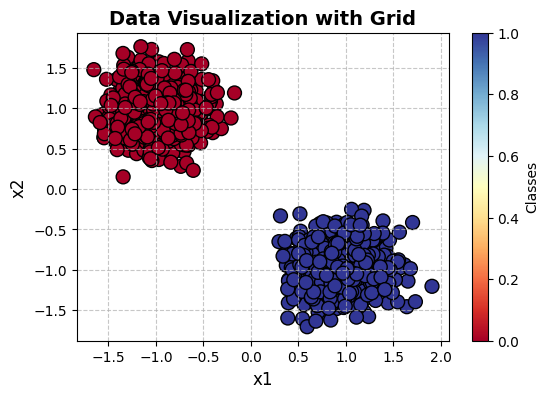

In [117]:
# let's plot the data
plt.figure(figsize=(6, 4))

# scatter plot with labels and grid
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', s=100)

# add title, labels, and grid
plt.title('Data Visualization with Grid', fontsize=14, fontweight='bold')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# display color bar to indicate classes
plt.colorbar(label='Classes')

# display the plot
plt.show()

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750,), (250, 2), (250,))

In [119]:

class SVM:
    def __init__(self, C=1.0):
        self.C = C  # Regularization parameter (for soft margin, though not used in this simple linear SVM)
        self.w = None
        self.b = None
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_alphas = None
    
    def fit(self, X, y):
        # Convert y from {0, 1} to {-1, 1} if needed
        y = np.where(y == 0, -1, y)
        
        # Store the training data
        self.X = X
        self.y = y
        m, n = X.shape

        # Compute the Gram matrix (Q = (y y^T) ∘ (X X^T))
        K = X @ X.T
        Q = np.outer(y, y) * K

        # Define the objective function for the QP problem
        def objective(alpha):
            # Objective function to minimize (converted from maximization form)
            return 0.5 * np.dot(alpha, np.dot(Q, alpha)) - np.sum(alpha)

        # Define the equality constraint (y^T alpha = 0)
        constraints = {
            'type': 'eq', 
            'fun': lambda alpha: np.dot(y, alpha),
            'jac': lambda alpha: y
        }

        # Bounds for alpha (all alpha >= 0)
        bounds = [(0, None) for _ in range(m)] 

        # Initial guess
        alpha0 = np.zeros(m)

        # Solve the QP problem using scipy.optimize.minimize
        result = minimize(objective, alpha0, bounds=bounds, constraints=constraints, method='SLSQP')
        self.alphas = result.x

        # Extract support vectors where alpha > epsilon
        epsilon = 1e-5
        support_vector_indices = np.where(self.alphas > epsilon)[0]
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.support_alphas = self.alphas[support_vector_indices]

        # Compute w 
        self.w = self.X.T @ (self.alphas * self.y)
        
        # Compute b using any support vector
        self.b = np.mean(
            [self.support_vector_labels[i] - np.dot(self.w, self.support_vectors[i]) 
                for i in range(len(self.support_alphas))]
        )

    def predict(self, X):
        # Make predictions based on the sign of the decision function
        return np.sign(np.dot(X, self.w) + self.b)

    def decision_function(self, X):
        # Compute the decision function values
        return np.dot(X, self.w) + self.b
    
    def plot_decision_boundary(self):
        # Plot the original data points
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='bwr', alpha=0.7, s=50)
        
        # Highlight the support vectors
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], 
                    s=100, facecolors='none', edgecolors='k', label='Support Vectors')
        
        # Create a grid to plot decision boundary and margins
        x_min, x_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        y_min, y_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Compute decision function values for the grid
        Z = self.decision_function(grid)
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary (where f(x) = 0)
        plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles=['-'], linewidths=1.5)
        
        # Plot the margin boundaries (where f(x) = ±1)
        plt.contour(xx, yy, Z, levels=[-1, 1], colors='k', linestyles=['--'], linewidths=1)
        
        # Customize the plot
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.title('SVM Decision Boundary with Margin and Support Vectors')
        plt.show()

In [120]:
model1 = SVM()
model1.fit(X_train, y_train)

In [121]:
model1.w, model1.b

(array([ 1.0662403 , -0.96257366]), 0.058657964448224464)

In [122]:
y_pred_train = model1.predict(X_train)
y_pred_train = np.where(y_pred_train == -1, 0, 1)
y_pred_test = model1.predict(X_test)
y_pred_test = np.where(y_pred_test == -1, 0, 1)

In [123]:
from sklearn.metrics import classification_report

In [124]:
# training set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00       368

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



In [125]:
# test set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00       132

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



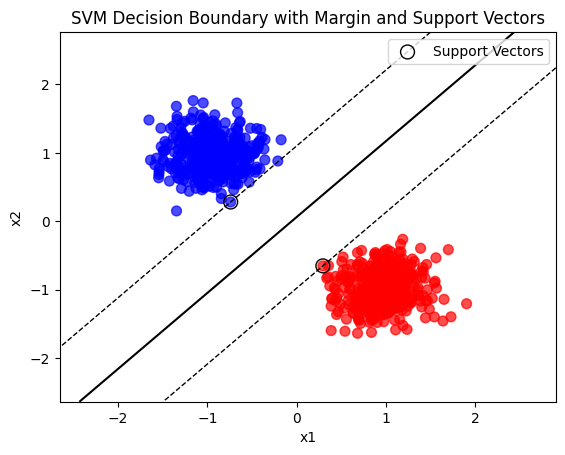

In [126]:
model1.plot_decision_boundary()

In [127]:
model1.support_vectors

array([[-0.73859961,  0.28167543],
       [ 0.29487123, -0.65131483]])

In [128]:
model1.support_vectors.shape

(2, 2)

In [130]:
model1.alphas 

array([0.00000000e+00, 0.00000000e+00, 2.76441689e-15, 0.00000000e+00,
       7.53304582e-15, 4.61833848e-15, 1.02807469e-15, 8.21922101e-15,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.15985766e-15,
       4.74148150e-15, 9.52304202e-15, 0.00000000e+00, 0.00000000e+00,
       6.37403455e-15, 0.00000000e+00, 0.00000000e+00, 4.48104121e-16,
       0.00000000e+00, 0.00000000e+00, 5.97651154e-16, 5.57073973e-15,
       0.00000000e+00, 8.57473839e-15, 0.00000000e+00, 6.17365696e-15,
       0.00000000e+00, 0.00000000e+00, 1.41003923e-15, 0.00000000e+00,
       8.55875576e-17, 2.00931301e-15, 1.31229723e-15, 7.68161254e-15,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.93252028e-16,
       9.60144013e-15, 5.76471414e-14, 0.00000000e+00, 1.19463976e-16,
       0.00000000e+00, 4.41888646e-15, 7.20112073e-15, 0.00000000e+00,
       2.13308677e-15, 1.79306236e-15, 1.23414640e-15, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.93903850e-15, 3.95561764e-15,
      